Import everything you need — including the model class (here it's GCNConv).

In [ ]:
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv  # Replace with GATConv, SAGEConv, etc.
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, mean_squared_error

# 🔁 Load datasets
task = "classification"  # or "regression"

train_data = torch.load(f"../4_train_test_split/random_split/{task}/{task}_train.pt")
val_data = torch.load(f"../4_train_test_split/random_split/{task}/{task}_val.pt")
test_data = torch.load(f"../4_train_test_split/random_split/{task}/{task}_test.pt")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

# 🧱 Define Model (GCN or MPNN or GraphSAGE, etc.)
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# 🧮 Loss and evaluation setup
if task == "classification":
    num_classes = len(set([int(data.y.item()) for data in train_data]))
    model = GCN(in_channels=train_data[0].x.size(1), hidden_channels=64, out_channels=num_classes)
    criterion = torch.nn.CrossEntropyLoss()
else:
    model = GCN(in_channels=train_data[0].x.size(1), hidden_channels=64, out_channels=1)
    criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 🏋️ Training loop
def train():
    model.train()
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out.squeeze(), batch.y if task == "regression" else batch.y.long())
        loss.backward()
        optimizer.step()

# 📈 Evaluation
def evaluate(loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.squeeze().cpu())
            labels.append(batch.y.cpu())
    preds = torch.cat(preds)
    labels = torch.cat(labels)

    if task == "classification":
        pred_classes = preds.argmax(dim=1)
        return accuracy_score(labels, pred_classes)
    else:
        return mean_squared_error(labels, preds)

# 🚀 Run training
for epoch in range(1, 101):
    train()
    metric = evaluate(val_loader)
    print(f"Epoch {epoch:03d} - {'Accuracy' if task == 'classification' else 'MSE'}: {metric:.4f}")

# ✅ Final test evaluation
test_metric = evaluate(test_loader)
print(f"\n🧪 Test {'Accuracy' if task == 'classification' else 'MSE'}: {test_metric:.4f}")


In [6]:
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv  # Replace with GATConv, SAGEConv, etc.
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, mean_squared_error
from torch_geometric.nn import GATConv, global_mean_pool

load the graph datasets  (the random split .pt files ) and specify what task you are doing

In [2]:
task = "classification"  # or "regression"

train_data = torch.load(f"../4_train_test_split/random_split/{task}/{task}_train.pt")
val_data = torch.load(f"../4_train_test_split/random_split/{task}/{task}_val.pt")
test_data = torch.load(f"../4_train_test_split/random_split/{task}/{task}_test.pt")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_96089/773147054.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(f"../4_train_test_spli

Define the model you want to use (GCN or MPNN or GraphSAGE, etc.)

In [7]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)  # Aggregate node features to graph level
        return self.lin(x)

In [9]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.lin = Linear(hidden_channels * heads, out_channels)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)  # Aggregate node features to graph level
        return self.lin(x)


setup loss and evaluation 

In [10]:
#GCN models

if task == "classification":
    num_classes = len(set([int(data.y.item()) for data in train_data]))
    model = GCN(in_channels=train_data[0].x.size(1), hidden_channels=64, out_channels=num_classes)
    criterion = torch.nn.CrossEntropyLoss()
else:
    model = GCN(in_channels=train_data[0].x.size(1), hidden_channels=64, out_channels=1)
    criterion = torch.nn.MSELoss()

In [14]:
if task == "classification":
    num_classes = len(set([int(data.y.item()) for data in train_data]))
    model = GAT(in_channels=train_data[0].x.size(1), hidden_channels=64, out_channels=num_classes, heads=8)
    criterion = torch.nn.CrossEntropyLoss()
else:
    model = GAT(in_channels=train_data[0].x.size(1), hidden_channels=64, out_channels=1, heads=8)
    criterion = torch.nn.MSELoss()

In [15]:


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 🏋️ Training loop
def train():
    model.train()
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out.squeeze(), batch.y if task == "regression" else batch.y.long())
        loss.backward()
        optimizer.step()

# 📈 Evaluation
def evaluate(loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.squeeze().cpu())
            labels.append(batch.y.cpu())
    preds = torch.cat(preds)
    labels = torch.cat(labels)

    if task == "classification":
        pred_classes = preds.argmax(dim=1)
        return accuracy_score(labels, pred_classes)
    else:
        return mean_squared_error(labels, preds)


🚀 Model training

In [13]:
for epoch in range(1, 101):
    train()
    metric = evaluate(val_loader)
    print(f"Epoch {epoch:03d} - {'Accuracy' if task == 'classification' else 'MSE'}: {metric:.4f}")

# ✅ Final test evaluation
test_metric = evaluate(test_loader)
print(f"\n🧪 Test {'Accuracy' if task == 'classification' else 'MSE'}: {test_metric:.4f}")

Epoch 001 - Accuracy: 0.5192
Epoch 002 - Accuracy: 0.5192
Epoch 003 - Accuracy: 0.5192
Epoch 004 - Accuracy: 0.4231
Epoch 005 - Accuracy: 0.5192
Epoch 006 - Accuracy: 0.6923
Epoch 007 - Accuracy: 0.6538
Epoch 008 - Accuracy: 0.5192
Epoch 009 - Accuracy: 0.6731
Epoch 010 - Accuracy: 0.6923
Epoch 011 - Accuracy: 0.6923
Epoch 012 - Accuracy: 0.6731
Epoch 013 - Accuracy: 0.7115
Epoch 014 - Accuracy: 0.6923
Epoch 015 - Accuracy: 0.6923
Epoch 016 - Accuracy: 0.6731
Epoch 017 - Accuracy: 0.6731
Epoch 018 - Accuracy: 0.6923
Epoch 019 - Accuracy: 0.6346
Epoch 020 - Accuracy: 0.6731
Epoch 021 - Accuracy: 0.6731
Epoch 022 - Accuracy: 0.6731
Epoch 023 - Accuracy: 0.6731
Epoch 024 - Accuracy: 0.6346
Epoch 025 - Accuracy: 0.6731
Epoch 026 - Accuracy: 0.6731
Epoch 027 - Accuracy: 0.6731
Epoch 028 - Accuracy: 0.6923
Epoch 029 - Accuracy: 0.6538
Epoch 030 - Accuracy: 0.6923
Epoch 031 - Accuracy: 0.6923
Epoch 032 - Accuracy: 0.6731
Epoch 033 - Accuracy: 0.6923
Epoch 034 - Accuracy: 0.6731
Epoch 035 - Ac

Epoch 001 - Train Accuracy: 0.7423, Val Accuracy: 0.7308
Epoch 002 - Train Accuracy: 0.7376, Val Accuracy: 0.7500
Epoch 003 - Train Accuracy: 0.7541, Val Accuracy: 0.7308
Epoch 004 - Train Accuracy: 0.7423, Val Accuracy: 0.7885
Epoch 005 - Train Accuracy: 0.7470, Val Accuracy: 0.7692
Epoch 006 - Train Accuracy: 0.7494, Val Accuracy: 0.7115
Epoch 007 - Train Accuracy: 0.7612, Val Accuracy: 0.7308
Epoch 008 - Train Accuracy: 0.7612, Val Accuracy: 0.7308
Epoch 009 - Train Accuracy: 0.7707, Val Accuracy: 0.7115
Epoch 010 - Train Accuracy: 0.7470, Val Accuracy: 0.7692
Epoch 011 - Train Accuracy: 0.7636, Val Accuracy: 0.7500
Epoch 012 - Train Accuracy: 0.7400, Val Accuracy: 0.7115
Epoch 013 - Train Accuracy: 0.7541, Val Accuracy: 0.7885
Epoch 014 - Train Accuracy: 0.7612, Val Accuracy: 0.7115
Epoch 015 - Train Accuracy: 0.7589, Val Accuracy: 0.7500
Epoch 016 - Train Accuracy: 0.7730, Val Accuracy: 0.7692
Epoch 017 - Train Accuracy: 0.7541, Val Accuracy: 0.7692
Epoch 018 - Train Accuracy: 0.7

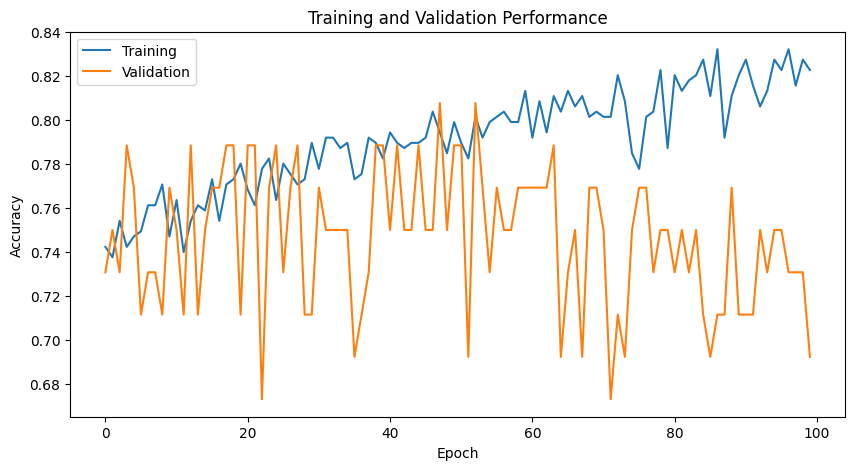

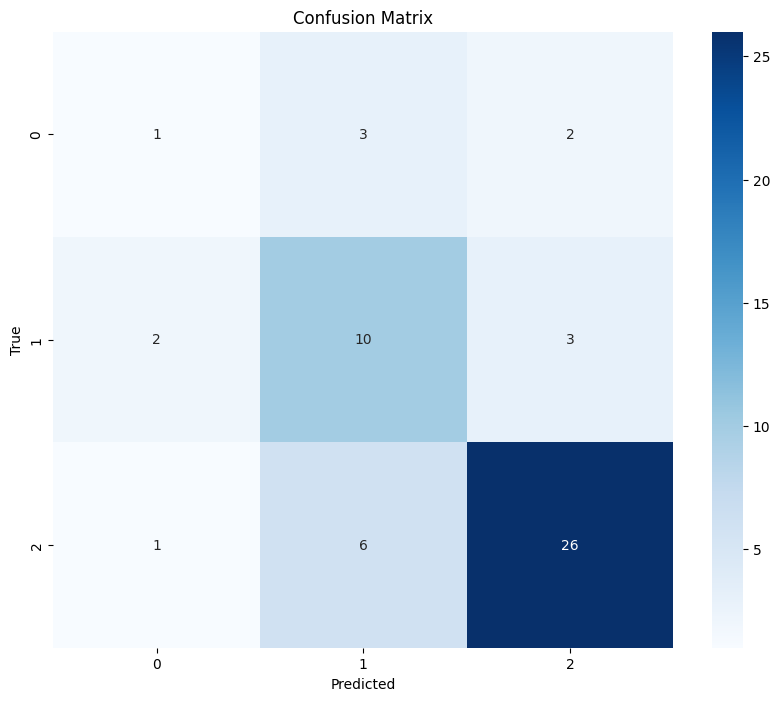

(tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 11, 12, 12, 13, 12, 14, 14, 15,  3, 16, 16, 17, 17, 18,
         18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 22, 24, 22, 25, 21, 26, 26, 27,
         17,  1, 27, 18, 10,  5, 15,  9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
         10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 11, 13, 12, 14, 12, 15, 14, 16,  3, 17, 16, 18, 17,
         19, 18, 20, 19, 21, 20, 22, 21, 23, 22, 24, 22, 25, 22, 26, 21, 27, 26,
          1, 17, 18, 27,  5, 10,  9, 15,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
         10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]]), tensor([[3.6930e-01, 8.5722e-05, 1.3614e-02, 4.3051e-04, 6.5667e-03, 9.8274e-01,
         2.1627e-01, 1.1060e-02],
        [4.1387e-01, 9.9977e-01, 9.7445e-01, 9.9921e-01, 9.9736e-01, 7

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

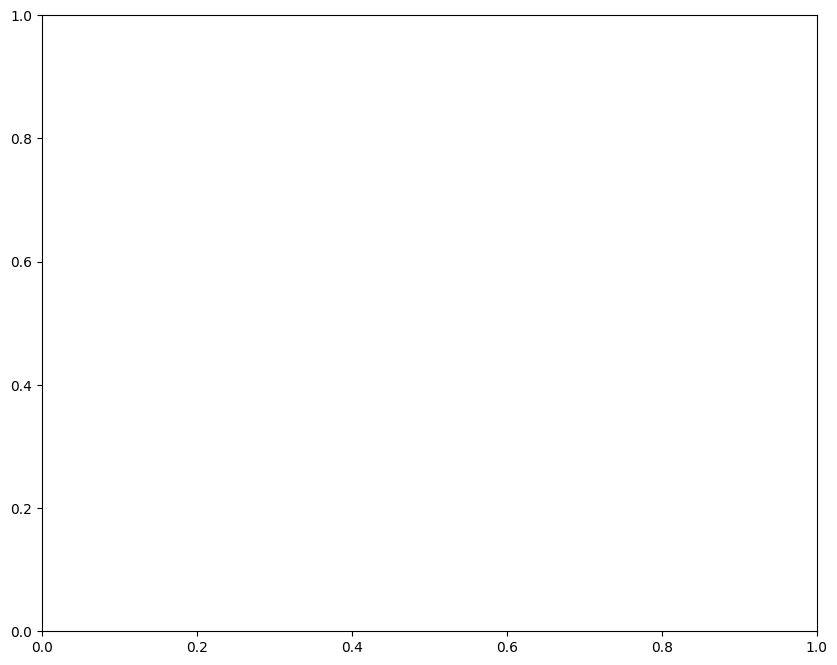

In [21]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Add history
train_history = []
val_history = []

# Training
for epoch in range(1, 101):
    train()
    train_metric = evaluate(train_loader)
    val_metric = evaluate(val_loader)
    train_history.append(train_metric)
    val_history.append(val_metric)
    print(f"Epoch {epoch:03d} - Train {'Accuracy' if task == 'classification' else 'MSE'}: {train_metric:.4f}, Val {'Accuracy' if task == 'classification' else 'MSE'}: {val_metric:.4f}")

# Plot training curve
plt.figure(figsize=(10, 5))
plt.plot(train_history, label='Training')
plt.plot(val_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy' if task == 'classification' else 'MSE')
plt.title('Training and Validation Performance')
plt.legend()
plt.show()

# Plot confusion matrix 
if task == "classification":
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

ValueError: 'c' argument has 26640 elements, which is inconsistent with 'x' and 'y' with size 3330.

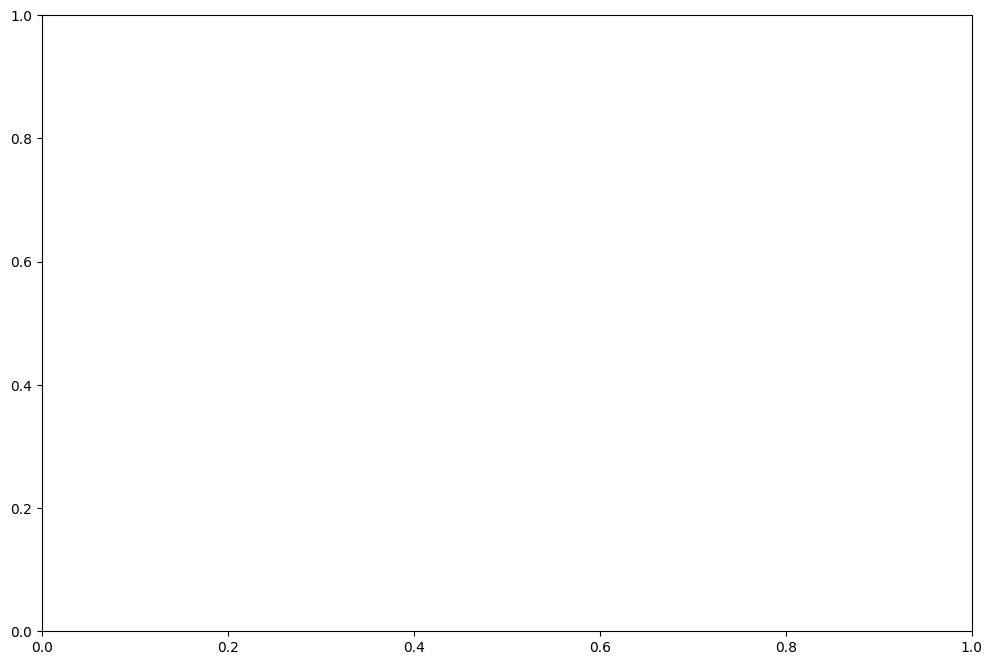

In [18]:
# Visualizing Attention Weights
def visualize_attention(model, data_loader):
    model.eval()
    # get first batch
    for batch in data_loader:
        batch = batch.to(device)
        with torch.no_grad():
            # get attention weights of first layer
            _, (edge_index, attn_weights) = model.conv1(batch.x, batch.edge_index, return_attention_weights=True)
            
            # convert to numpy array
            attn_weights = attn_weights.cpu().numpy()
            edge_index = edge_index.cpu().numpy()
            
            # plot attention weights
            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(edge_index[0], edge_index[1], c=attn_weights, 
                                cmap='viridis', s=100, alpha=0.6)
            plt.colorbar(scatter, label='Attention Weight')
            plt.title('Attention Weights Visualization')
            plt.xlabel('Source Node')
            plt.ylabel('Target Node')
            plt.grid(True, alpha=0.3)
            plt.show()
            
            # only visualize the first batch
            break

# Visualize for the test loader
visualize_attention(model, test_loader)

ValueError: 'c' argument has 26640 elements, which is inconsistent with 'x' and 'y' with size 3330.

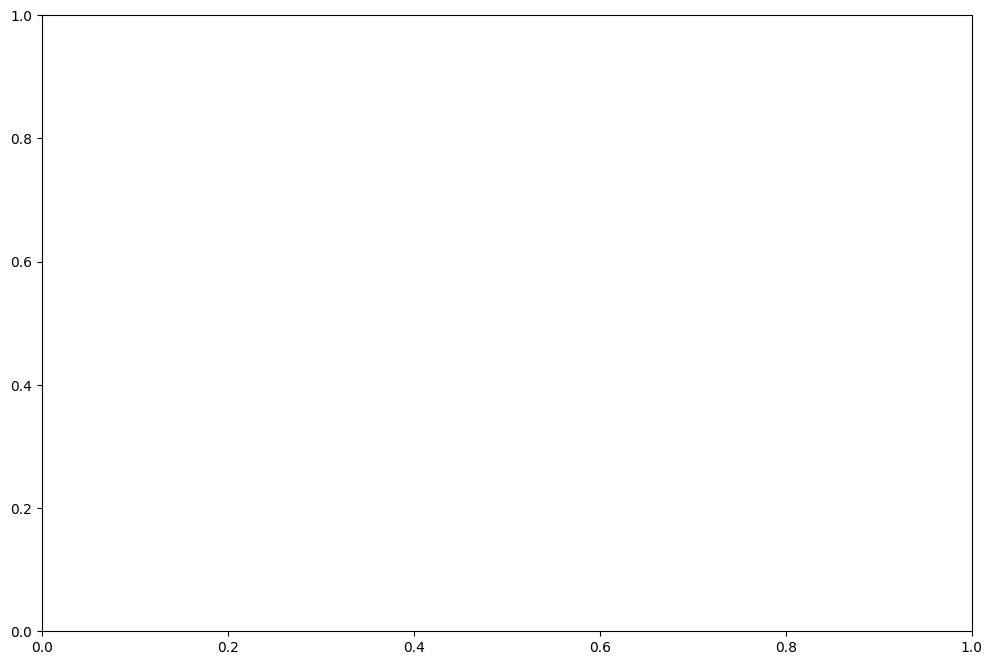

In [ ]:
# Visualizing Attention Weights (Ver. 2)
def visualize_attention(model, data_loader):
    model.eval()
    # get first batch
    for batch in data_loader:
        batch = batch.to(device)
        with torch.no_grad():
            # get attention for the first layer
            _, (edge_index, attn_weights) = model.conv1(batch.x, batch.edge_index, return_attention_weights=True)
            
            # convert to numpy arrayes
            attn_weights = attn_weights.cpu().numpy()
            edge_index = edge_index.cpu().numpy()
            
            # make sure the dimensions match
            if attn_weights.shape[0] != edge_index.shape[1]:
                # if not match, take the average
                attn_weights = attn_weights.mean(axis=0)
            
            # plot attention weights
            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(edge_index[0], edge_index[1], c=attn_weights, 
                                cmap='viridis', s=100, alpha=0.6)
            plt.colorbar(scatter, label='Attention Weight')
            plt.title('Attention Weights Visualization')
            plt.xlabel('Source Node')
            plt.ylabel('Target Node')
            plt.grid(True, alpha=0.3)
            plt.show()
            
            # only visualize the first batch
            break

# Visualizing the test_loader
visualize_attention(model, test_loader)
